<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es entrenar un modelo de lenguaje basado en arquitectura de redes recurrentes a partir de un corpus de texto. En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la perplejidad. Parte del ejercicio consiste en estructurar adecuadamente el dataset para este problema.

In [64]:
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from scipy.special import softmax

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [65]:

if not os.path.exists('./songs_dataset'):
    if not os.path.exists('songs_dataset.zip'):
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip



In [66]:
# Posibles bandas
os.listdir("./songs_dataset/")

['adele.txt',
 'beatles.txt',
 'bieber.txt',
 'leonard-cohen.txt',
 'dj-khaled.txt',
 'alicia-keys.txt',
 'kanye.txt',
 'missy-elliott.txt',
 'cake.txt',
 'kanye-west.txt',
 'lin-manuel-miranda.txt',
 'michael-jackson.txt',
 'joni-mitchell.txt',
 'lil-wayne.txt',
 'bruno-mars.txt',
 'ludacris.txt',
 'eminem.txt',
 'jimi-hendrix.txt',
 'radiohead.txt',
 'paul-simon.txt',
 'dolly-parton.txt',
 'janisjoplin.txt',
 'notorious-big.txt',
 'bjork.txt',
 'bob-dylan.txt',
 'johnny-cash.txt',
 'dickinson.txt',
 'Kanye_West.txt',
 'amy-winehouse.txt',
 'prince.txt',
 'notorious_big.txt',
 'drake.txt',
 'britney-spears.txt',
 'bruce-springsteen.txt',
 'dr-seuss.txt',
 'nursery_rhymes.txt',
 'r-kelly.txt',
 'blink-182.txt',
 'patti-smith.txt',
 'nicki-minaj.txt',
 'nickelback.txt',
 'bob-marley.txt',
 'Lil_Wayne.txt',
 'disney.txt',
 'lorde.txt',
 'nirvana.txt',
 'lady-gaga.txt',
 'rihanna.txt',
 'al-green.txt']

In [67]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

/tmp/ipython-input-3849064916.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


In [68]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [69]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


### Elegir el tamaño del contexto

In [70]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [71]:
# cada verso lo guardamos en una lista
text = list(df[0])
text

['Yesterday, all my troubles seemed so far away',
 "Now it looks as though they're here to stay",
 "Oh, I believe in yesterday Suddenly, I'm not half the man I used to be",
 "There's a shadow hanging over me.",
 "Oh, yesterday came suddenly Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 "Oh, I believe in yesterday Why she had to go I don't know she wouldn't say",
 'I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play',
 'Now I need a place to hide away',
 'Oh, I believe in yesterday',
 'Mm mm mm mm mm mm mm When I find myself in times of trouble, Mother Mary comes to me',
 'Speaking words of wisdom, let it be',
 'And in my hour of darkness she is standing right in front of me',
 'Speaking words of wisdom, let it be',
 'Let it be, let it be, let it be, let it be',
 'Whisper words of wisdom, let it be And when

In [72]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [73]:
# calculamos la longitud de cada secuencia
length_sentences = [len(s) for s in segmented_sentences]

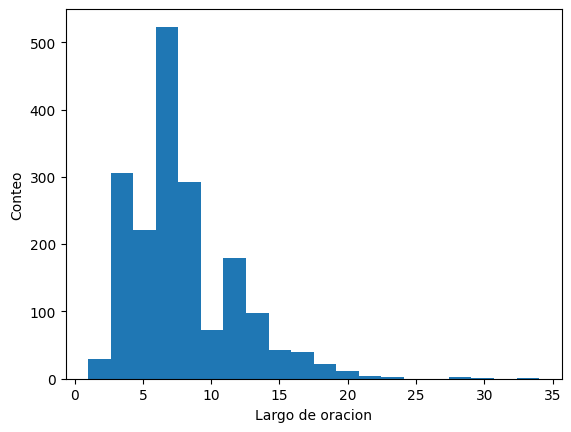

In [74]:
# podemos ver su distribución
plt.hist(length_sentences, bins=20)
plt.xlabel("Largo de oracion")
plt.ylabel("Conteo")
plt.show()

In [75]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 12


###  Tokenizar

In [76]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [77]:
tokenized_sentences

[[200, 10, 12, 907, 908, 42, 909, 121],
 [22, 13, 638, 91, 217, 349, 79, 4, 314],
 [23, 2, 160, 9, 200, 520, 35, 83, 910, 3, 78, 2, 911, 4, 15],
 [173, 7, 912, 913, 397, 8],
 [23, 200, 218, 520, 100, 19, 138, 4, 61, 2, 27, 14, 19, 446, 21],
 [2,
  174,
  187,
  350,
  22,
  2,
  96,
  41,
  200,
  200,
  6,
  50,
  255,
  161,
  256,
  521,
  4,
  228],
 [22, 2, 43, 7, 229, 4, 188, 121],
 [23, 2, 160, 9, 200, 100, 19, 138, 4, 61, 2, 27, 14, 19, 446, 21],
 [2,
  174,
  187,
  350,
  22,
  2,
  96,
  41,
  200,
  200,
  6,
  50,
  255,
  161,
  256,
  521,
  4,
  228],
 [22, 2, 43, 7, 229, 4, 188, 121],
 [23, 2, 160, 9, 200],
 [175,
  175,
  175,
  175,
  175,
  175,
  175,
  36,
  2,
  230,
  522,
  9,
  398,
  17,
  914,
  639,
  640,
  133,
  4,
  8],
 [447, 162, 17, 315, 29, 13, 15],
 [5, 9, 12, 915, 17, 916, 19, 20, 189, 74, 9, 917, 17, 8],
 [447, 162, 17, 315, 29, 13, 15],
 [29, 13, 15, 29, 13, 15, 29, 13, 15, 29, 13, 15],
 [448, 162, 17, 315, 29, 13, 15, 5, 36, 3, 399, 918, 107, 3

In [78]:
vocab_size = len(tok.word_index)

In [79]:
max_context_size+1

13

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [80]:
tokenized_sentences_train, tokenized_sentences_val = train_test_split(tokenized_sentences, test_size=0.2, random_state=42)


Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [81]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [82]:
len(tok_sent)

1957

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [83]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [84]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [85]:
train_seqs.shape

(15325, 13)

In [86]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [87]:
y.shape

(15325,)

In [88]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'love',
 7: 'a',
 8: 'me',
 9: 'in',
 10: 'all',
 11: 'nah',
 12: 'my',
 13: 'it',
 14: 'know',
 15: 'be',
 16: 'that',
 17: 'of',
 18: 'on',
 19: 'she',
 20: 'is',
 21: 'say',
 22: 'now',
 23: 'oh',
 24: 'yeah',
 25: 'your',
 26: 'get',
 27: "don't",
 28: 'back',
 29: 'let',
 30: 'with',
 31: 'her',
 32: 'can',
 33: "it's",
 34: 'do',
 35: "i'm",
 36: 'when',
 37: 'come',
 38: 'will',
 39: 'he',
 40: 'but',
 41: 'for',
 42: 'so',
 43: 'need',
 44: 'there',
 45: 'like',
 46: 'no',
 47: 'together',
 48: "i'll",
 49: 'see',
 50: 'was',
 51: 'never',
 52: 'we',
 53: 'down',
 54: 'way',
 55: 'if',
 56: 'want',
 57: 'out',
 58: 'hey',
 59: 'one',
 60: 'got',
 61: 'go',
 62: 'well',
 63: "can't",
 64: 'girl',
 65: 'good',
 66: 'his',
 67: 'sun',
 68: 'they',
 69: 'home',
 70: 'hello',
 71: 'day',
 72: 'are',
 73: 'ah',
 74: 'right',
 75: 'little',
 76: 'at',
 77: 'from',
 78: 'man',
 79: 'here',
 80: 'help',
 81: 'gonna',
 82: 'have',
 

In [89]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1628

In [90]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'you': 1, 'i': 2, 'the': 3, 'to': 4, 'and': 5, 'love': 6, 'a': 7, 'me': 8, 'in': 9, 'all': 10, 'nah': 11, 'my': 12, 'it': 13, 'know': 14, 'be': 15, 'that': 16, 'of': 17, 'on': 18, 'she': 19, 'is': 20, 'say': 21, 'now': 22, 'oh': 23, 'yeah': 24, 'your': 25, 'get': 26, "don't": 27, 'back': 28, 'let': 29, 'with': 30, 'her': 31, 'can': 32, "it's": 33, 'do': 34, "i'm": 35, 'when': 36, 'come': 37, 'will': 38, 'he': 39, 'but': 40, 'for': 41, 'so': 42, 'need': 43, 'there': 44, 'like': 45, 'no': 46, 'together': 47, "i'll": 48, 'see': 49, 'was': 50, 'never': 51, 'we': 52, 'down': 53, 'way': 54, 'if': 55, 'want': 56, 'out': 57, 'hey': 58, 'one': 59, 'got': 60, 'go': 61, 'well': 62, "can't": 63, 'girl': 64, 'good': 65, 'his': 66, 'sun': 67, 'they': 68, 'home': 69, 'hello': 70, 'day': 71, 'are': 72, 'ah': 73, 'right': 74, 'little': 75, 'at': 76, 'from': 77, 'man': 78, 'here': 79, 'help': 80, 'gonna': 81, 'have': 82, 'not': 83, 'world': 84, 'going': 85, 'what': 86, 'still': 87, 'how': 88, 'too': 89

In [91]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'yesterday': 10, 'far': 1, 'seemed': 1, 'so': 61, 'troubles': 1, 'away': 21, 'all': 177, 'my': 134, 'looks': 2, "they're": 5, 'now': 90, 'as': 25, 'though': 11, 'it': 125, 'here': 33, 'stay': 7, 'to': 307, "i'm": 66, 'believe': 15, 'man': 34, 'the': 376, 'half': 1, 'used': 1, 'not': 32, 'be': 108, 'suddenly': 3, 'oh': 77, 'in': 186, 'i': 400, 'a': 270, "there's": 14, 'hanging': 1, 'me': 219, 'over': 5, 'shadow': 1, 'why': 20, 'go': 38, "don't": 74, 'came': 11, 'had': 19, 'say': 76, 'know': 132, 'she': 90, "wouldn't": 4, 'said': 14, 'play': 10, 'something': 13, 'wrong': 6, 'long': 25, 'game': 3, 'love': 181, 'an': 15, 'easy': 9, 'such': 9, 'was': 48, 'for': 62, 'hide': 13, 'place': 10, 'need': 51, 'of': 109, 'myself': 3, 'trouble': 1, 'mary': 2, 'times': 5, 'when': 71, 'comes': 20, 'find': 10, 'mother': 2, 'mm': 3, 'let': 55, 'words': 14, 'speaking': 4, 'wisdom': 7, 'hour': 1, 'standing': 13, 'front': 1, 'right': 25, 'and': 311, 'is': 89, 'darkness': 1, 'brok

In [92]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

# Supongamos que ya tenés:
# X.shape = (15325, 12)
# y.shape = (15325, 1)

# Split (80% train, 20% valid, por ejemplo)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.squeeze(), dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.squeeze(), dtype=torch.long)

# Dataset y DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)



### Perplexity


In [93]:
import math

def perplexity(loss_value: float) -> float:
    """Calcula perplexity a partir del valor de loss promedio."""
    try:
        return math.exp(loss_value)
    except OverflowError:
        return float('inf')


### Definir el modelo

In [94]:
class TextModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=5, hidden_dim=64, num_classes=None, max_context_size=3):
        super(TextModel, self).__init__()

        # Embedding:
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=embed_dim)

        # LSTMs: el primero devuelve secuencia completa
        self.lstm1 = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, vocab_size+1)

    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, embed_dim)

        # Primer LSTM: return_sequences=True equivale a quedarse con toda la salida
        x, _ = self.lstm1(x)   # (batch, seq_len, hidden_dim)
        x = self.dropout(x)

        # Segundo LSTM: sin return_sequences -> solo último estado oculto
        x, (h_n, c_n) = self.lstm2(x)  # x = (batch, seq_len, hidden_dim)
        x = h_n[-1]                    # último hidden state: (batch, hidden_dim)

        x = F.relu(self.fc1(x))
        logits = self.fc2(x)           # (batch, vocab_size+1)
        return logits

    def predict(self,x):
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

In [95]:
model = TextModel(vocab_size=vocab_size, embed_dim=5, hidden_dim=64, num_classes=vocab_size+1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Entrenamiento
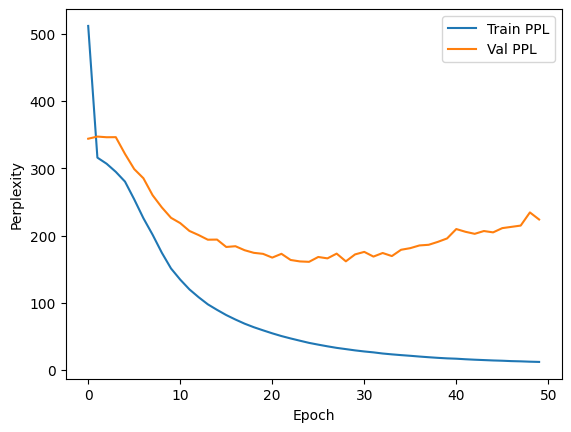

In [96]:
epochs = 30

# Historial de métricas
history = {
    "train_loss": [],
    "val_loss": [],
    "train_ppl": [],
    "val_ppl": [],
    "val_acc": []
}

for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    train_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)  # (batch, vocab_size+1)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    avg_train_loss = train_loss / len(train_ds)
    train_ppl = perplexity(avg_train_loss)

    # --- Validación ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    avg_val_loss = val_loss / len(val_ds)
    val_ppl = perplexity(avg_val_loss)
    val_acc = correct / total

    # Guardar métricas
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_ppl"].append(train_ppl)
    history["val_ppl"].append(val_ppl)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_ppl:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_ppl:.2f}"
          )

Epoch 1/30 | Train Loss: 6.2251 | Train PPL: 505.26 | Val Loss: 5.8370 | Val PPL: 342.74
Epoch 2/30 | Train Loss: 5.7511 | Train PPL: 314.54 | Val Loss: 5.8292 | Val PPL: 340.09
Epoch 3/30 | Train Loss: 5.6982 | Train PPL: 298.34 | Val Loss: 5.8075 | Val PPL: 332.78
Epoch 4/30 | Train Loss: 5.6639 | Train PPL: 288.26 | Val Loss: 5.7945 | Val PPL: 328.49
Epoch 5/30 | Train Loss: 5.6326 | Train PPL: 279.40 | Val Loss: 5.7879 | Val PPL: 326.34
Epoch 6/30 | Train Loss: 5.5902 | Train PPL: 267.80 | Val Loss: 5.7473 | Val PPL: 313.33
Epoch 7/30 | Train Loss: 5.5232 | Train PPL: 250.43 | Val Loss: 5.6826 | Val PPL: 293.72
Epoch 8/30 | Train Loss: 5.3825 | Train PPL: 217.57 | Val Loss: 5.5717 | Val PPL: 262.87
Epoch 9/30 | Train Loss: 5.2172 | Train PPL: 184.42 | Val Loss: 5.4814 | Val PPL: 240.18
Epoch 10/30 | Train Loss: 5.0628 | Train PPL: 158.03 | Val Loss: 5.3829 | Val PPL: 217.64
Epoch 11/30 | Train Loss: 4.9247 | Train PPL: 137.64 | Val Loss: 5.3329 | Val PPL: 207.03
Epoch 12/30 | Train

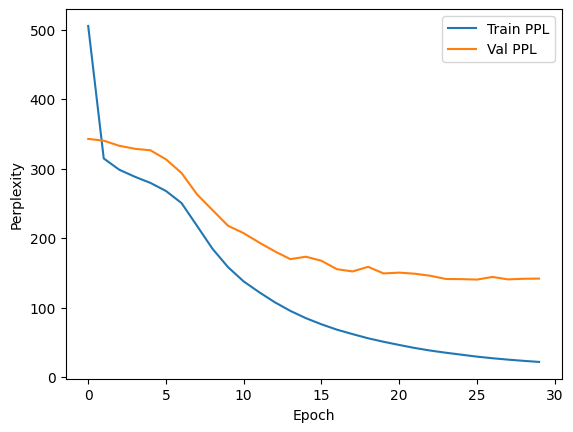

In [97]:
import matplotlib.pyplot as plt

plt.plot(history["train_ppl"], label="Train PPL")
plt.plot(history["val_ppl"], label="Val PPL")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.show()


In [98]:
import torch

def predict_next_word(model, tokenizer, text, max_len, device="cpu"):
    model.eval()

    # Codificar texto a secuencia de índices
    encoded = tokenizer.texts_to_sequences([text])[0]

    # Padding/truncamiento manual
    if len(encoded) < max_len:
        encoded = [0] * (max_len - len(encoded)) + encoded
    else:
        encoded = encoded[-max_len:]

    # Convertir a tensor y mover a device
    x = torch.as_tensor([encoded], dtype=torch.long, device=device)

    with torch.no_grad():
        y_hat = model.forward(x)  # logits (1, vocab_size+1)

    # Índice de la palabra predicha
    idx = y_hat.argmax(dim=1).item()

    # Buscar la palabra en el tokenizer
    for word, i in tokenizer.word_index.items():
        if i == idx:
            return word
    return ""  # fallback si no encuentra

def generate_seq(model, tokenizer, seed_text, n_words, max_len, device="cpu"):
    output = seed_text
    for _ in range(n_words):
        next_word = predict_next_word(model, tokenizer, output, max_len, device)
        output += " " + next_word
    return output





### Predicción de próxima palabra

In [100]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [101]:
import gradio as gr

def model_response(human_text,device="cpu"):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    encoded_tens = torch.as_tensor(encoded, dtype=torch.long, device=device)

    y_hat = model.predict(encoded_tens).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7571bab5ccd563f32f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://7571bab5ccd563f32f.gradio.live


### Generación de secuencias

In [114]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        encoded = torch.as_tensor(encoded, dtype=torch.long)
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [118]:
input_text='we all live in a yellow'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=4)

'we all live in a yellow submarine submarine doo doo'

###  Beam search y muestreo aleatorio

In [119]:
# funcionalidades para hacer encoding y decoding

def decode(seq):
    if isinstance(seq, torch.Tensor):
      # desconectar del grafo, mover a cpu, convertir a lista
      seq = seq.detach().cpu().tolist()
    return tok.sequences_to_texts([seq])[0]


def encode(text, tok=tok, max_length=max_context_size,device="cpu"):
    # Convertir texto a secuencia de enteros con tokenizer de Keras
    encoded = tok.texts_to_sequences([text])[0]  # lista de ints

    # Convertir a tensor long
    encoded = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)   # (1, seq_len)

    # Padding manual al inicio (equivale a 'pre' en Keras)
    if len(encoded) < max_length:
        pad_len = max_length - len(encoded)
        encoded = F.pad(encoded, (pad_len, 0), value=0)
    else:
        encoded = encoded[-max_length:]

    return encoded  # shape: (max_length,)

In [135]:
from scipy.special import softmax

# función que selecciona candidatos para el beam searchimport numpy as np
import torch
import torch.nn.functional as F

def select_candidates(preds, num_beams, vocab_size, history_probs, history_tokens, temp=1.0):
    """
    preds: lista de arrays (cada uno de shape [vocab_size]) con distribuciones de probabilidad
    history_probs: lista con log-probs acumuladas hasta ahora
    history_tokens: lista de secuencias de tokens
    """
    pred_large = []

    # aplanar todas las opciones posibles
    for idx, pp in enumerate(preds):
        # pp ya está en probs, convertimos a log-probs + acumulado
        pred_large.extend(np.log(pp + 1e-10) + history_probs[idx])

    pred_large = np.array(pred_large)

    # selección de candidatos
    # determinista:
    # idx_select = np.argsort(pred_large)[::-1][:num_beams]
    # estocástico:
    probs = np.exp(pred_large / temp)
    probs = probs / probs.sum()
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=probs)

    # traducir a índices de tokens
    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size],
         np.array([idx_select % vocab_size]).T),
        axis=1
    )

    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model, num_beams, num_words,input,temp=1.0,tok=tok, max_len=max_context_size,device="cpu"):
    model.eval()

    # encode texto inicial
    encoded = encode(input_text, tok, max_len)   # (seq_len,)
    encoded = encoded.to(device)    # (1, seq_len)

    with torch.no_grad():
        y_hat = model(encoded)                   # (1, vocab_size)
        y_hat = F.softmax(y_hat, dim=-1).cpu().numpy().squeeze()  # distribución inicial

    vocab_size = y_hat.shape[0]

    # inicialización
    history_probs = [0] * num_beams
    history_tokens = [encoded.cpu().numpy().flatten()] * num_beams

    # primera selección
    history_probs, history_tokens = select_candidates(
        [y_hat], num_beams, vocab_size, history_probs, history_tokens
    )

    # loop beam search
    for i in range(num_words - 1):
        preds = []

        for hist in history_tokens:
            input_update = torch.tensor(hist[-max_len:], dtype=torch.long, device=device).unsqueeze(0)

            with torch.no_grad():
                y_hat = model(input_update)          # (1, vocab_size)
                y_hat = F.softmax(y_hat, dim=-1).cpu().numpy().squeeze()

            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(
            preds, num_beams, vocab_size, history_probs, history_tokens,temp
        )

    return history_tokens


In [174]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="when i find myself in times",temp=0.1)
# veamos las salidas
decode(salidas[0])

'we all live in a yellow party going can talk no no'

### Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.